# Unsupervised method for First break picking

* [Dataset](#Dataset)
* [Model](#Model)
* [Energy function](#Energy-function)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../../picking/SeismicPro/')

from seismicpro.batchflow import B, V
from seismicpro.src import FieldIndex, TraceIndex, seismic_plot, SeismicDataset, SeismicBatch
from seismicpro.models import PickingMetrics

Index field records with FB time as a separate column:

In [2]:
markup_path = '/notebooks/picking/data/targets.csv'
path_raw = '/notebooks/picking/data/traces.sgy'

In [3]:
import pandas as pd
data = pd.read_csv(markup_path)
data.head()
ind = FieldIndex(name='raw', path=path_raw).get_df()
new_path = ind.file_id.iloc[0]['raw']
data.file_id = new_path
data.to_csv(markup_path, index=False)

In [4]:
index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)

In [5]:
batch = (SeismicDataset(index).next_batch(batch_size=1)
        .load(components='raw', fmt='segy')
        .load(components='markup', fmt='picks'))

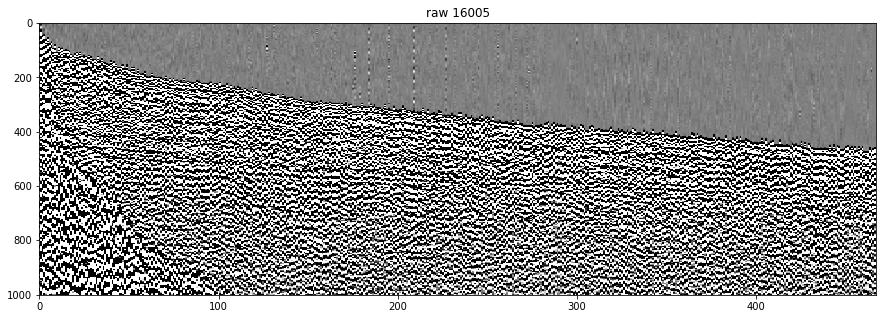

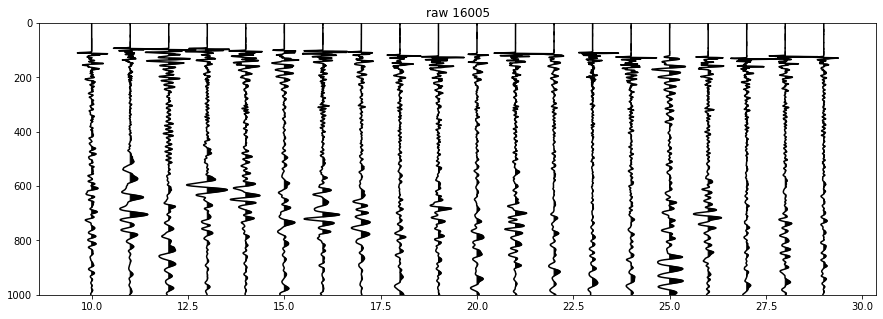

In [6]:
cv = 1000
(batch.seismic_plot('raw', index.indices[0], cmap='gray', figsize=(15,5), vmax=cv, vmin=-cv)
      .seismic_plot('raw', index.indices[0], cmap='gray', figsize=(15,5), vmax=cv, vmin=-cv,
                    wiggle=True, xlim=(10, 30), ylim=(0,1000), std=0.1))

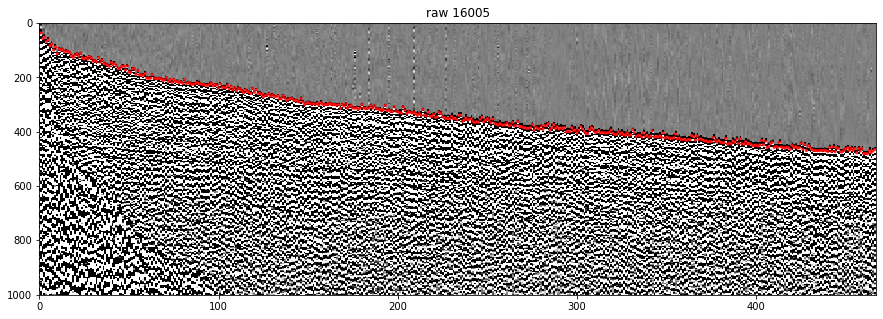

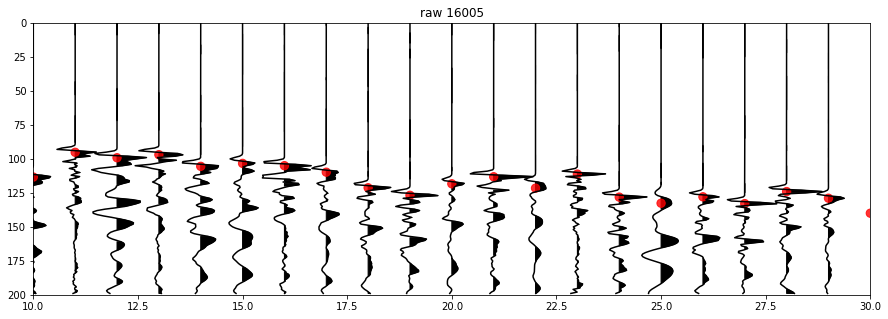

In [7]:
cv = 1000
(batch.seismic_plot('raw', index.indices[0], src_picking='markup', cmap='gray',
                     figsize=(15,5), vmax=cv, vmin=-cv, s=5, scatter_color='r')
      .seismic_plot('raw', index.indices[0], src_picking='markup', cmap='gray',
                    figsize=(15,5), vmax=cv, vmin=-cv, s=70, scatter_color='r',
                    wiggle=True, xlim=(10, 30), ylim=(0,200), std=0.1))

In [8]:
index = index.create_subset(index.indices[:10])
data = SeismicDataset(TraceIndex(index), batch_class=SeismicBatch)

## Model

The basic idea of this strategy is very simple and follows [Coppen's method](https://www.researchgate.net/publication/249866374_Automatic_first-breaks_picking_New_strategies_and_algorithms). The aim of the method is to distinguish the signal from the incoherent or coherent background noise in terms of their energy difference.

Every trace goes through same preprocessing actions:   
* Loading.
* Standartization.
* Clipping values.
* Calculating energy function and its derivative.
* Calculating FB time.

In [9]:
cv = 3
pipeline = (data.p
                .load(components='raw', fmt='segy')
                .load(components='markup', fmt='picks')
                .standardize(src='raw', dst='raw')
                .init_variable('raw', [])
                .update(V('raw', mode='a'), B('raw'))
#                .clip(a_min=-cv, a_max=cv, src='raw', dst='raw')
                .init_variable('true', [])
                .update(V('true', mode='a'), B('markup'))
                .mcm(src='raw', dst='energy', eps=0.1, length_win=20)
                .energy_to_picking(src='energy', dst='predictions')
                .init_variable('predictions', [])
                .update(V('predictions', mode='a'), B('predictions'))
           )

Run the pipeline for 1000 traces.

In [10]:
batch = pipeline.next_batch(batch_size=1000)

## Energy function

For this purpose, we calculate the energy of the seismic trace  within two nested windows.

$$E_{1}(t) = \sum_{i = t - n_{l} + 1}^{t} {s_{i}}^2 ,$$

$$ E_{2}(t) = \sum_{i = 1}^{t} {s_{i}}^2, $$

where  $ {n_l} $ is the length of the first leading window, a parameter thatis fixed and selected a priori.   
Then we calculate the energy ratio.

$$ ER(t) = {{E_{1}(t)} \over {{E_{2}(t) + \beta}}}, $$

where $\beta$ is a stabilization constant that helps reduce the rapid fluctuations of $ER(t)$.   

Take a look at raw seismic trace and corresponding energy function.

In [11]:
n = 200

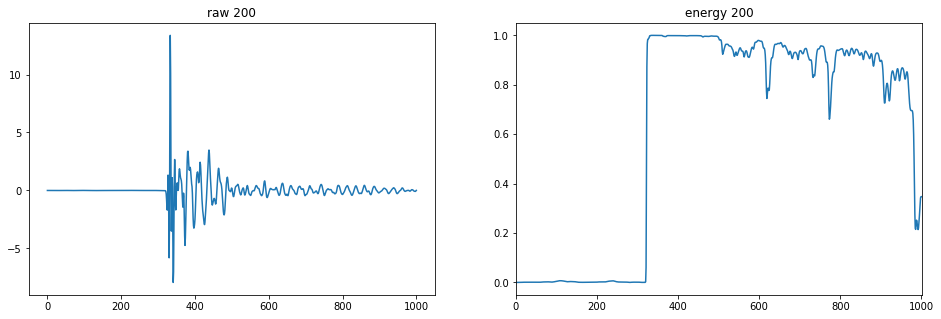

In [12]:
batch.seismic_plot(['raw', 'energy'], index=n, figsize=(16,5))
plt.show()

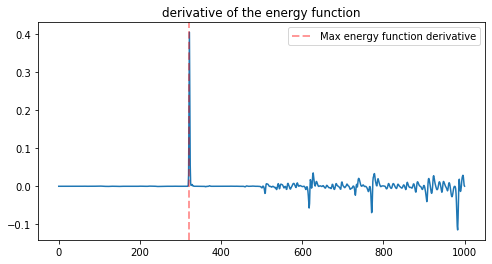

In [13]:
plt.figure(figsize=(8,4))
plt.title('derivative of the energy function')
ax1 = plt.plot(np.gradient(batch.energy[n]))
ax2 = plt.axvline(np.argmax(np.gradient(batch.energy[n])), linewidth=2, c='r', linestyle='--', alpha=0.4)
plt.legend([ax2], ['Max energy function derivative'])
plt.show()

## Inference

Run the inference pipeline on the whole dataset.

In [14]:
pipeline.run(batch_size=1000, n_epochs=1, bar=True)

100%|██████████| 5/5 [00:00<00:00, 22.47it/s]


## Model evaluation

Arrange results.

In [15]:
true = np.round(np.concatenate(np.concatenate(pipeline.get_variable('true'))) / 2)
pred = np.concatenate(pipeline.get_variable('predictions')) 
traces = np.concatenate(np.concatenate(pipeline.get_variable('raw')))

#### Visual estimation

Take a look at the whole seismigram and model predictions.

Take a closer look. Ten first traces of the field.

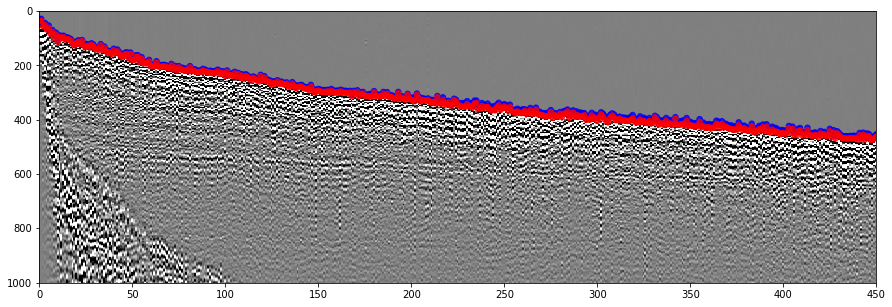

In [16]:
cv = 1
xlim = (0, 450)

pts_pred = (range(len(pred)), pred)
pts_true = (range(len(true)), true)

seismic_plot(traces, cmap='gray', vmin=-cv, vmax=cv, pts=[pts_pred, pts_true], s=30,
             scatter_color=['b', 'r'], figsize=(15,5), xlim=xlim)

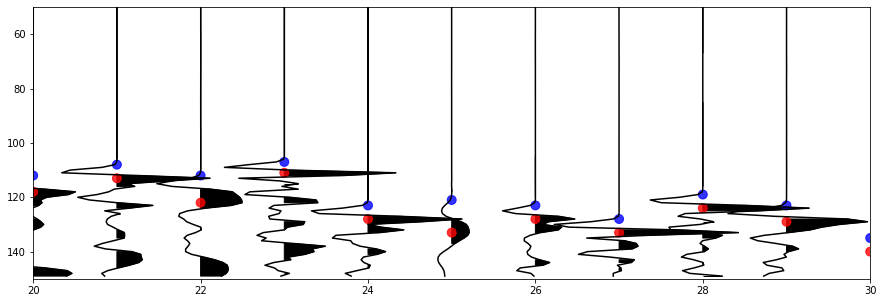

In [17]:
std = 0.1
xlim = (20, 30)
ylim = (50, 150)

pts_pred = (range(len(pred)), pred)
pts_true = (range(len(true)), true)

seismic_plot(traces, cmap='gray', vmin=-cv, vmax=cv, pts=[pts_pred, pts_true], s=80,
             scatter_color=['b', 'r'], figsize=(15,5),
             xlim=xlim, ylim=ylim, wiggle=True, std=std)

The model finds kind of first minimum instead of maximum.

#### Mean absolute error

In [18]:
print('MAE on validation: {0:.3f}'.format(np.mean(true - pred)))

MAE on validation: 8.940


## Criticism

Despite being old, Coppens’s method  is very robust when the S/N is high. If the first break is impulsive such as in dynamite or marine data, the performance of the CM is decent. However, if the first arrival is not very abrupt such as in vibroseis data, usually ER attains its maximum at a earlier time, limiting the capabilities of the CM to detect the exact location of the first break

## Conclusion.

We presented unsupervised Coppen's method for First break picking task, which can be simply implemented.   
The model has two parameters $n_{l}$ - leading window length  and $\beta$ - stabilization constant which must be manually adjusted in oder to get decent results.   
Due to inconsistency among seismic traces on the same field the model prone to miss first arrival time on the traces with low signal rate.